# **Feast_AI** 🍔

As an introductory project to myself, I built an **end-to-end CNN Image Classification Model** which identifies the food in your image.

I worked out with a pretrained Image Classification Model that comes with Keras and then retrained it on the infamous **Food101 Dataset**.


**Fun Fact :**

The Model actually beats the DeepFood Paper's model which also trained on the same dataset.

The Accuracy of [**DeepFood**](https://arxiv.org/abs/1606.05675) was **77.4%** and our model's is **85%**. Difference of **8%** ain't much but the interesting thing is, DeepFood's model took 2-3 days to train while our's was around 60min.

> **Dataset :** `Food101`

> **Model :** `EfficientNetB1`





## **Setting up the Workspace**

* Checking the GPU
* Mounting Google Drive
* Importing Tensorflow
* Importing other required Packages

### **Checking the GPU**

For this Project we will working with **Mixed Precision**. And mixed precision works best with a with a GPU with compatibility capacity **7.0+**.

At the time of writing, colab offers the following GPU's :
* Nvidia K80
* **Nvidia T4**
* Nvidia P100

Colab allocates a random GPU everytime we factory reset runtime. So you can reset the runtime till you get a **Tesla T4 GPU** as T4 GPU has a rating 7.5.

> In case using local hardware, use a GPU with rating 7.0+ for better results.

Run the below cell to see which GPU is allocated to you.

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-491a8ce0-aca7-f5fa-51ed-989017bfa52a)
GPU 1: Tesla T4 (UUID: GPU-80997a69-5189-8f70-f018-fef60f0a7af3)


### **Importing Tensorflow**

At the time of writing, `tesnorflow 2.5.0` has a bug with EfficientNet Models. [Click Here](https://github.com/tensorflow/tensorflow/issues/49725) to get more info about the bug. Hopefully tensorflow fixes it soon.

So the below code is used to downgrade the version to `tensorflow 2.4.1`, it will take a moment to uninstall the previous version and install our required version.

> You need to restart the **Runtime** after required version of tensorflow is installed.

**Note :** Restarting runtime won't assign you a new GPU.

### **Importing other required Packages**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import tensorflow_datasets as tfds
import seaborn as sn

#### **Importing `helper_fuctions`**

The `helper_functions.py` is a python script created by me. Which has some important functions I use frequently while building Deep Learning Models.

In [3]:
!wget https://raw.githubusercontent.com/gauravreddy08/deep-learning-tensorflow/main/extras/helper_function.py

--2025-02-17 19:45:48--  https://raw.githubusercontent.com/gauravreddy08/deep-learning-tensorflow/main/extras/helper_function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_function.py’

helper_function.py  100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-02-17 19:45:48 (66.0 MB/s) - ‘helper_function.py’ saved [10246/10246]



In [4]:
from helper_function import plot_loss_curves, load_and_prep_image

## **Getting the Data Ready**

The Dataset used is **Food101**, which is available on both Kaggle and Tensorflow.

In the below cells we will be importing Datasets from `Tensorflow Datasets` Module.


In [5]:
# Prints list of Datasets avaible in Tensorflow Datasets Module

dataset_list = tfds.list_builders()
dataset_list[:10]

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'ai2dcaption',
 'aloha_mobile',
 'amazon_us_reviews']

### **Importing Food101 Dataset**

**Disclaimer :**
The below cell will take time to run, as it will be downloading
**4.65GB data** from **Tensorflow Datasets Module**.

So do check if you have enough **Disk Space** and **Bandwidth Cap** to run the below cell.

In [6]:
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.WTUAKW_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.WTUAKW_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## **Becoming One with the Data**

One of the most important steps in building any ML or DL Model is to **become one with the data**.

Once you get the gist of what type of data your dealing with and how it is structured, everything else will fall in place.

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
train_one_sample = train_data.take(1)

In [10]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
for image, label in train_one_sample:
  print(f"""
  Image Shape : {image.shape}
  Image Datatype : {image.dtype}
  Class : {class_names[label.numpy()]}
  """)


  Image Shape : (512, 512, 3)
  Image Datatype : <dtype: 'uint8'>
  Class : grilled_cheese_sandwich
  


In [12]:
image[:2]

<tf.Tensor: shape=(2, 512, 3), dtype=uint8, numpy=
array([[[239, 217, 157],
        [244, 222, 162],
        [247, 227, 168],
        ...,
        [119, 104,  73],
        [111,  95,  70],
        [105,  89,  66]],

       [[233, 212, 149],
        [239, 218, 155],
        [243, 223, 162],
        ...,
        [117, 102,  71],
        [108,  92,  67],
        [101,  85,  62]]], dtype=uint8)>

In [13]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

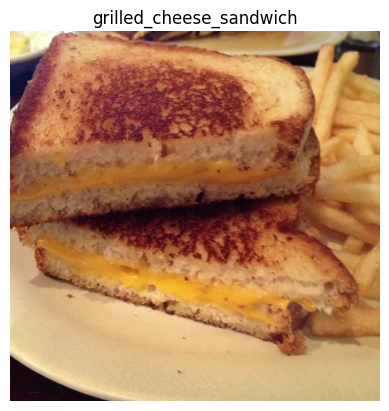

In [14]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## **Preprocessing the Data**

Since we've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps we have to take before it's ready to model.

More specifically, our data is currently:

* In `uint8` data type
* Comprised of all differnet sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

* In `float32` data type
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. `(224, 224, 3)`)
* Scaled (values between 0 & 1), also called normalized

To take care of these, we'll create a `preprocess_img()` function which:

* Resizes an input image tensor to a specified size using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize)
* Converts an input image tensor's current datatype to `tf.float32` using [`tf.cast()`](https://www.tensorflow.org/api_docs/python/tf/cast)

In [15]:
def preprocess_img(image, label, img_size=224):
  image = tf.image.resize(image, [img_size, img_size])
  image = tf.cast(image, tf.float16)
  return image, label

In [16]:
# Trying the preprocess function on a single image

preprocessed_img = preprocess_img(image, label)[0]
preprocessed_img

<tf.Tensor: shape=(224, 224, 3), dtype=float16, numpy=
array([[[238.8  , 217.4  , 155.5  ],
        [242.9  , 222.9  , 162.5  ],
        [240.9  , 220.2  , 164.2  ],
        ...,
        [131.2  , 118.3  ,  75.75 ],
        [123.9  , 109.8  ,  75.1  ],
        [106.7  ,  90.7  ,  66.44 ]],

       [[232.1  , 212.1  , 141.4  ],
        [238.9  , 219.9  , 151.1  ],
        [240.   , 221.1  , 155.9  ],
        ...,
        [127.5  , 112.5  ,  71.06 ],
        [122.6  , 106.56 ,  72.9  ],
        [105.8  ,  88.5  ,  63.2  ]],

       [[235.9  , 217.1  , 137.4  ],
        [240.8  , 223.8  , 145.6  ],
        [247.   , 229.2  , 156.   ],
        ...,
        [126.7  , 111.7  ,  71.1  ],
        [120.8  , 104.75 ,  71.   ],
        [105.56 ,  88.3  ,  62.6  ]],

       ...,

       [[ 34.78 ,   6.785,  18.78 ],
        [ 33.78 ,   5.785,  17.78 ],
        [ 35.25 ,   6.832,  18.83 ],
        ...,
        [195.4  , 178.4  , 126.06 ],
        [194.   , 177.   , 125.   ],
        [195.5  , 178.5

In [17]:
train_data = train_data.map(preprocess_img, tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, tf.data.AUTOTUNE)
test_data = test_data.batch(32)

In [18]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float16, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [19]:
test_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float16, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## **Building the Model : EfficientNetB1**


### **Getting the Callbacks ready**
As we are dealing with a complex Neural Network (EfficientNetB0) its a good practice to have few call backs set up. Few callbacks I will be using throughtout this Notebook are :
 * **TensorBoard Callback :** TensorBoard provides the visualization and tooling needed for machine learning experimentation

 * **EarlyStoppingCallback :** Used to stop training when a monitored metric has stopped improving.

 * **ReduceLROnPlateau :** Reduce learning rate when a metric has stopped improving.


 We already have **TensorBoardCallBack** function setup in out helper function, all we have to do is get other callbacks ready.

In [20]:
from helper_function import create_tensorboard_callback

In [21]:
# EarlyStopping Callback

early_stopping_callback = tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=3, verbose=1, monitor="val_accuracy")

In [22]:
# ReduceLROnPlateau Callback

lower_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2,
                                                monitor='val_accuracy',
                                                min_lr=1e-5,
                                                patience=2,
                                                verbose=1)



### **Mixed Precision Training**
Mixed precision is used for training neural networks, reducing training time and memory requirements without affecting the model performance.

More Specifically, in **Mixed Precision** we will setting global dtype as `mixed_float16`. Because modern accelerators can run operations faster in the 16-bit dtypes, as they have specialized hardware to run 16-bit computations and 16-bit dtypes can be read from memory faster.

To know more about Mixed Precision, [**click here**](https://www.tensorflow.org/guide/mixed_precision)

In [23]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy='mixed_float16')

In [24]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">



### **Building the Model**

In [25]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation

# Define input shape
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB1(include_top=False)

# Input and Data Augmentation
inputs = layers.Input(shape=input_shape, name="input_layer")

# Optional: Add data augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2)
])
x = data_augmentation(inputs)

# Feature extraction
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dropout(0.3)(x)

# Output layer
x = layers.Dense(len(class_names))(x)  # Ensure 'class_names' is defined
outputs = layers.Activation("softmax")(x)

# Build model
model = tf.keras.Model(inputs, outputs)

# Compile model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb1 (Functional)          │ (None, 7, 7, 1280)          │       6,575,239 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_layer                        │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,704,620 (25.58 MB)

 Trainable params: 6,642,565 (25.34 MB)

 Non-trainable params: 62,055 (242.41 KB)

In [27]:
history = model.fit(train_data,
                    epochs=12,
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    callbacks=[
                        create_tensorboard_callback("training-logs", "EfficientNetB1-"),
                        early_stopping_callback,
                        lower_lr
                    ])

Saving TensorBoard log files to: training-logs/EfficientNetB1-/20250217-195341
Epoch 1/12
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1019s 403ms/step - accuracy: 0.4032 - loss: 2.4794 - val_accuracy: 0.6623 - val_loss: 1.2170 - learning_rate: 0.0010
Epoch 2/12
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 956s 403ms/step - accuracy: 0.6445 - loss: 1.3563 - val_accuracy: 0.6618 - val_loss: 1.2498 - learning_rate: 0.0010
Epoch 3/12
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 956s 403ms/step - accuracy: 0.6897 - loss: 1.1592 - val_accuracy: 0.7338 - val_loss: 0.9723 - learning_rate: 0.0010
Epoch 4/12
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 956s 403ms/step - accuracy: 0.7220 - loss: 1.0421 - val_accuracy: 0.7166 - val_loss: 1.0735 - learning_rate: 0.0010
Epoch 5/12
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 963s 406ms/step - accuracy: 0.7441 - loss: 0.9474 - val_accuracy: 0.7635 - val_loss: 0.8662 - learning_rate: 0.0010
Epoch 6/12
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 958s 404ms/step - accuracy: 0.7587 - loss: 0.8755 - val_accuracy: 0.7534 - val_loss: 0.9

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 964s 407ms/step - accuracy: 0.8361 - loss: 0.5867 - val_accuracy: 0.8424 - val_loss: 0.5850 - learning_rate: 2.0000e-04
Epoch 9/12
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 980s 413ms/step - accuracy: 0.8740 - loss: 0.4430 - val_accuracy: 0.8353 - val_loss: 0.6221 - learning_rate: 2.0000e-04
Epoch 10/12
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.8829 - loss: 0.3988
Epoch 10: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 965s 407ms/step - accuracy: 0.8829 - loss: 0.3988 - val_accuracy: 0.8318 - val_loss: 0.6379 - learning_rate: 2.0000e-04
Epoch 11/12
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 955s 403ms/step - accuracy: 0.9031 - loss: 0.3294 - val_accuracy: 0.8422 - val_loss: 0.6092 - learning_rate: 4.0000e-05
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 8.


In [28]:

# Save in Keras format
model.save("/kaggle/working/FinalModel_1.0.keras")


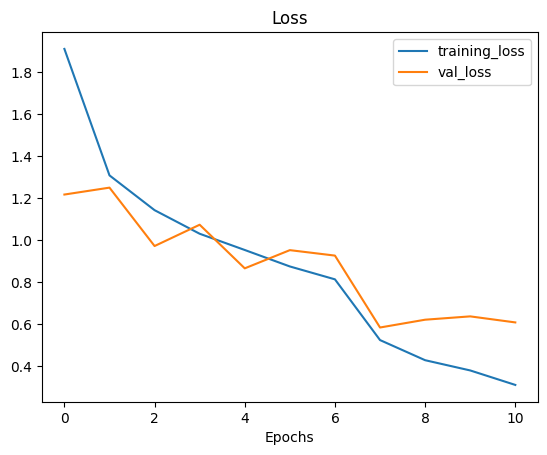

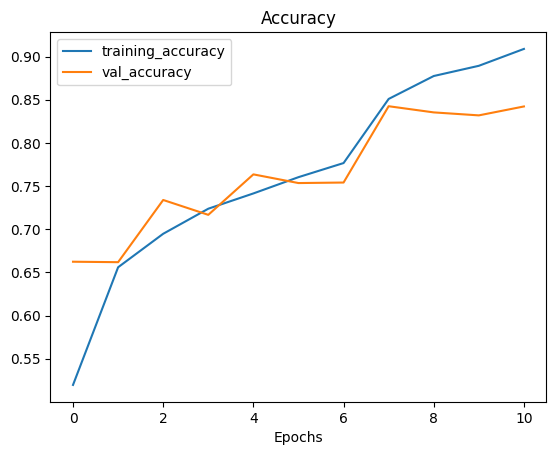

In [29]:
plot_loss_curves(history)

In [30]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 67s 84ms/step - accuracy: 0.8379 - loss: 0.5993


[0.602534830570221, 0.8371089100837708]

## **Evaluating our Model**

In [31]:
%load_ext tensorboard
%tensorboard --logdir training-logs

<IPython.core.display.Javascript object>

In [32]:
pred_probs = model.predict(test_data, verbose=1)
len(pred_probs), pred_probs.shape

790/790 ━━━━━━━━━━━━━━━━━━━━ 65s 78ms/step


(25250, (25250, 101))

In [33]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10], len(pred_classes), pred_classes.shape

(array([93,  4, 98, 40, 60, 13, 48, 92, 21, 25]), 25250, (25250,))

In [34]:
# Getting true labels for the test_data

y_labels = []
test_images = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())
y_labels[:10]

[84, 60, 29, 90, 33, 9, 12, 78, 77, 96]

In [35]:
# Predicted Labels vs. True Labels
pred_classes==y_labels

array([False, False, False, ..., False, False, False])

### **Sklearn's Accuracy Score**

In [36]:
from sklearn.metrics import accuracy_score

sklearn_acc = accuracy_score(y_labels, pred_classes)
sklearn_acc

0.010772277227722771

### **Confusion Matrix**
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known

In [37]:
cm = tf.math.confusion_matrix(y_labels, pred_classes)

plt.figure(figsize = (200, 200));
sn.heatmap(cm, annot=True,
           fmt='',
           cmap='Blues');

### **Model's Class-wise Accuracy Score**

In [38]:
from sklearn.metrics import classification_report
report = (classification_report(y_labels, pred_classes, output_dict=True))

In [39]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in report.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.0,
 'baby_back_ribs': 0.015503875968992248,
 'baklava': 0.008016032064128256,
 'beef_carpaccio': 0.0072992700729927005,
 'beef_tartare': 0.004301075268817204,
 'beet_salad': 0.003929273084479372,
 'beignets': 0.015444015444015444,
 'bibimbap': 0.0039447731755424065,
 'bread_pudding': 0.016194331983805668,
 'breakfast_burrito': 0.025641025641025644,
 'bruschetta': 0.00823045267489712,
 'caesar_salad': 0.00816326530612245,
 'cannoli': 0.011857707509881424,
 'caprese_salad': 0.003883495145631068,
 'carrot_cake': 0.021231422505307858,
 'ceviche': 0.015594541910331385,
 'cheesecake': 0.003952569169960474,
 'cheese_plate': 0.012024048096192386,
 'chicken_curry': 0.00865800865800866,
 'chicken_quesadilla': 0.004246284501061571,
 'chicken_wings': 0.020576131687242795,
 'chocolate_cake': 0.010676156583629894,
 'chocolate_mousse': 0.010452961672473867,
 'churros': 0.0040650406504065045,
 'clam_chowder': 0.031746031746031744,
 'club_sandwich': 0.007952286282306162,
 'crab_cakes': 

In [40]:
report_df = pd.DataFrame(class_f1_scores, index = ['f1-scores']).T

In [41]:
report_df = report_df.sort_values("f1-scores", ascending=True)